# Цветовая коррекция изображений

2. Серый мир

In [522]:
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [524]:
def get_image(path):
    return Image.open(path)

In [581]:
def gray_world(image):
    copy = image.copy()
    pixels = copy.load()
    
    r_sum = 0
    g_sum = 0
    b_sum = 0
    
    for i in range(image.width):
        for j in range(image.height):
            r_sum += pixels[i, j][0]
            g_sum += pixels[i, j][1]
            b_sum += pixels[i, j][2]

    n = image.width * image.height
    r_sum /= n
    g_sum /= n
    b_sum /= n

    average = (r_sum / 3 + g_sum / 3 + b_sum / 3)

    for i in range(image.width):
        for j in range(image.height):
            r = int(pixels[i, j][0] * (average / r_sum))
            g = int(pixels[i, j][1] * (average / g_sum))
            b = int(pixels[i, j][2] * (average / b_sum))
            
            pixels[i, j] = (r, g, b)
    return copy

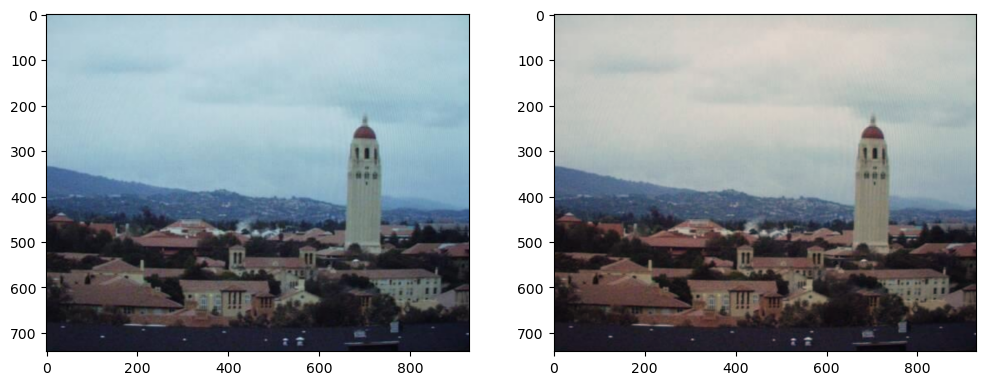

In [528]:
image = get_image("gray_world.png")
fig = plt.figure(figsize=(12, 9)) 
fig.add_subplot(1, 2, 1)
plt.imshow(image)
image = gray_world(image)
fig.add_subplot(1, 2, 2)
plt.imshow(image)

In [529]:
def reference_color(image, source, destination):
    copy = image.copy()
    pixels = copy.load()
    
    for i in range(image.width):
        for j in range(image.height):
            r = pixels[i, j][0]
            g = pixels[i, j][1]
            b = pixels[i, j][2]
            
            r = int(r * (destination[0] / (source[0])))
            g = int(g * (destination[1] / (source[1])))
            b = int(b * (destination[2] / (source[2])))
            pixels[i, j] = (r, g, b)
        
    return copy

1. Коррекция с опорным цветом

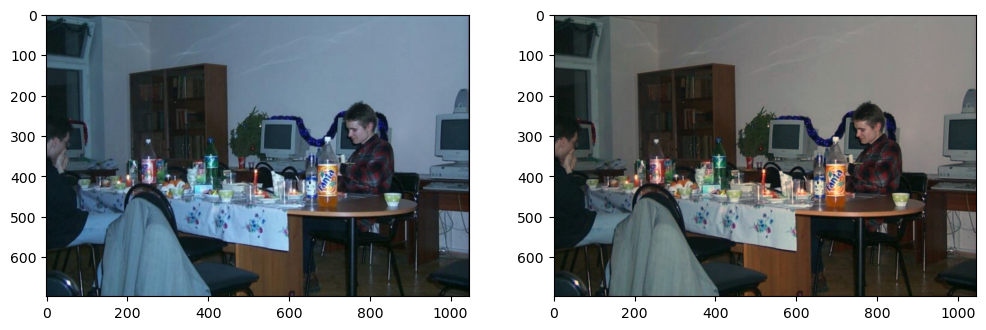

In [583]:
image = get_image("reference_color.png")
fig = plt.figure(figsize=(12, 9)) 
fig.add_subplot(1, 2, 1)
plt.imshow(image)
image = reference_color(image, (126, 148, 172), (144, 139, 136))
fig.add_subplot(1, 2, 2)
plt.imshow(image)

3. По виду функции преобразования

In [585]:
def linear_function(image, y_min, y_max):
    copy = image.copy()
    pixels = copy.load()

    r = 0
    g = 0
    b = 0

    for i in range(image.width):
        for j in range(image.height):
            r = int((pixels[i, j][0]- y_min) * 255 / (y_max - y_min))
            g = int((pixels[i, j][1]- y_min) * 255 / (y_max - y_min))
            b = int((pixels[i, j][2]- y_min) * 255 / (y_max - y_min))
            pixels[i, j] = (r, g, b)
            
    return copy

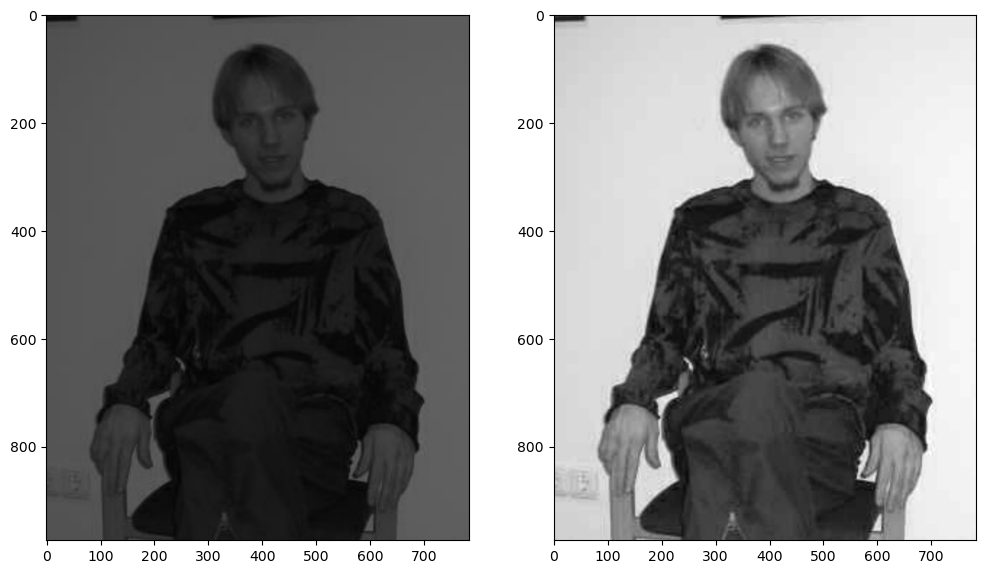

In [588]:
image = get_image("linear.png")
fig = plt.figure(figsize=(12, 9)) 
fig.add_subplot(1, 2, 1)
plt.imshow(image)
image = linear_function(image, 0, 100)
fig.add_subplot(1, 2, 2)
plt.imshow(image)

# Коррекция на основе гистограммы

1. Нормализация гистограммы

In [591]:
def normalize_histogram(image, values):
    copy = image.copy()
    pixels = image.load()

    p_min = 255
    p_max = 0
    
    for i in range(values.size):
        if(values[i] != 0):
            p_min = i
            break

    for i in range(values.size-1, 0, -1):
        if(values[i] != 0):
            p_max = i
            break
    
    for i in range(image.width):
        for j in range(image.height):
            pixels[i,j] = int((pixels[i, j]- p_min) * 255 / (p_max - p_min))
   
    values, _ = np.histogram( np.array(image).flatten(), bins=256, range=[0, 256])
    return (copy, values)

In [615]:
def get_histogram_values(image):
    values, _ = np.histogram(np.array(image).flatten(), bins=256, range=[0, 256])
    return values

In [617]:
def draw_histogram(values, width=1.0):
    indexes = [i for i in range(256)]
    plt.bar(indexes, values, color='black', width=width)

In [619]:
def get_histogram_bins(image):
    _, bins = np.histogram(np.array(image).flatten(), bins=256, range=[0, 256])
    return bins

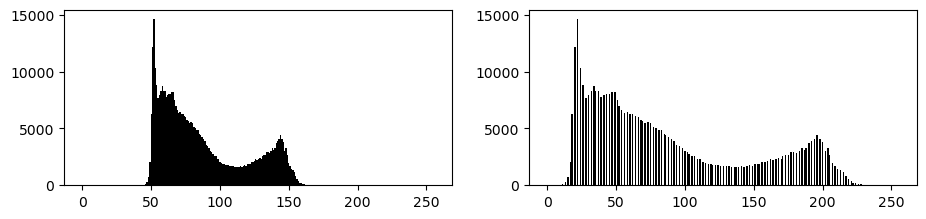

In [621]:
image = get_image("histogram.png")

fig = plt.figure(figsize=(11, 5)) 
fig.add_subplot(2, 2, 1)
values = get_histogram_values(image.convert('L'))
draw_histogram(values)

new_image, new_values = normalize_histogram(image.convert('L'), values)

fig.add_subplot(2, 2, 2)
draw_histogram(new_values)
plt.show()

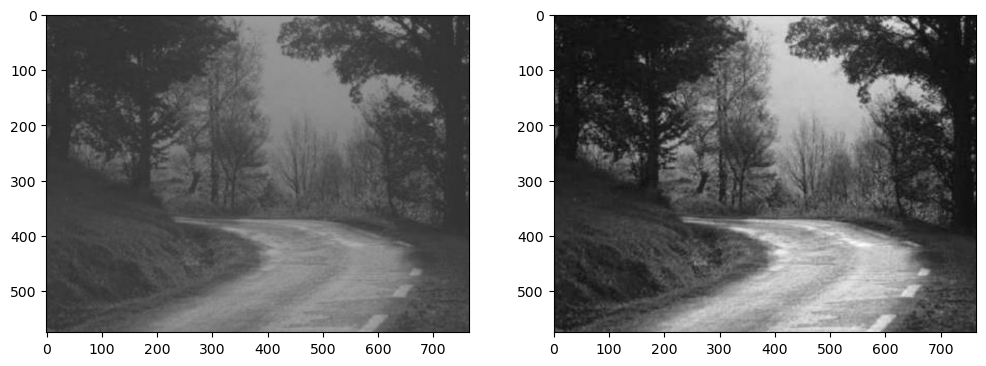

In [622]:
fig = plt.figure(figsize=(12, 9)) 
fig.add_subplot(1, 2, 1)
plt.imshow(image, cmap="gray")
fig.add_subplot(1, 2, 2)
plt.imshow(new_image, cmap="gray")

2. Эквализация гистограммы

In [626]:
def equalize_histogram(image, values, bins):
    pixels = image.load()
    array = np.array(image)

    cdf = values.cumsum()
    cdf_normalized = (cdf - cdf.min()) * 255 / (cdf.max() - cdf.min())

    normalized_image = np.interp(array.flatten(), bins[:-1], cdf_normalized)
    normalized_image = normalized_image.reshape(image.size[1], image.size[0]).astype(np.uint8)
   
    values, _ = np.histogram(normalized_image.flatten(), bins=256, range=[0, 256])
    return (Image.fromarray(normalized_image), values)

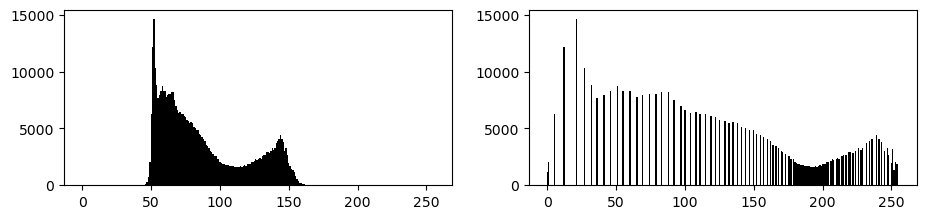

In [628]:
image = get_image("histogram.png")

fig = plt.figure(figsize=(11, 5)) 
fig.add_subplot(2, 2, 1)
values = get_histogram_values(image.convert('L'))
draw_histogram(values)

bins = get_histogram_bins(image.convert('L'))
new_image, new_values = equalize_histogram(image.convert('L'), values, bins)

fig.add_subplot(2, 2, 2)
draw_histogram(new_values)
plt.show()

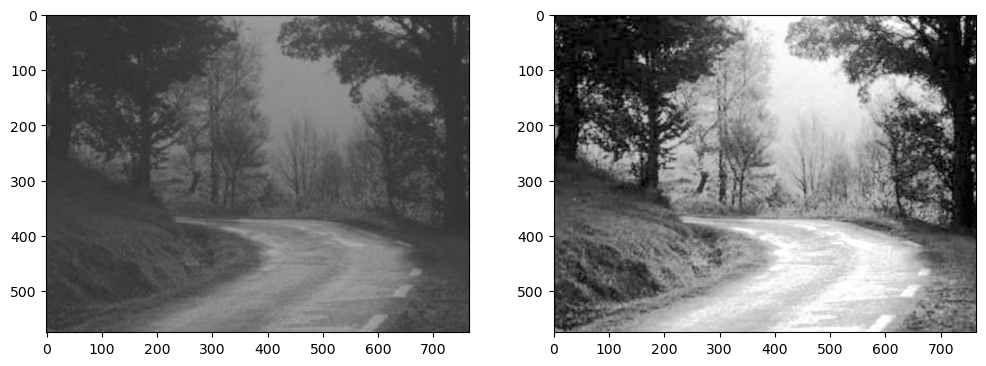

In [629]:
fig = plt.figure(figsize=(12, 9)) 
fig.add_subplot(1, 2, 1)
plt.imshow(image, cmap="gray")
fig.add_subplot(1, 2, 2)
plt.imshow(new_image, cmap="gray")